In [1]:
# Data manipulation
import numpy as np
import pandas as pd

# Date handling
import datetime
from datetime import date

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

# Preprocessing
from sklearn.preprocessing import StandardScaler, normalize

# Clustering
from sklearn.mixture import GaussianMixture

# Association Rules
from mlxtend.frequent_patterns import apriori, association_rules

# Warnings
import warnings
warnings.filterwarnings('ignore')


In [2]:
df = pd.read_csv("marketing_campaign.csv")

print(df.head())

  ID\tYear_Birth\tEducation\tMarital_Status\tIncome\tKidhome\tTeenhome\tDt_Customer\tRecency\tMntWines\tMntFruits\tMntMeatProducts\tMntFishProducts\tMntSweetProducts\tMntGoldProds\tNumDealsPurchases\tNumWebPurchases\tNumCatalogPurchases\tNumStorePurchases\tNumWebVisitsMonth\tAcceptedCmp3\tAcceptedCmp4\tAcceptedCmp5\tAcceptedCmp1\tAcceptedCmp2\tComplain\tZ_CostContact\tZ_Revenue\tResponse
0  5524\t1957\tGraduation\tSingle\t58138\t0\t0\t0...                                                                                                                                                                                                                                                                                                                                                  
1  2174\t1954\tGraduation\tSingle\t46344\t1\t1\t0...                                                                                                                                                                      

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 1 columns):
 #   Column                                                                                                                                                                                                                                                                                                                                                                    Non-Null Count  Dtype 
---  ------                                                                                                                                                                                                                                                                                                                                                                    --------------  ----- 
 0   ID	Year_Birth	Education	Marital_Status	Income	Kidhome	Teenhome	Dt_Customer	Recency	MntWines	MntFruits	MntMeat

In [4]:

# Use tab separator
data = pd.read_csv("marketing_campaign.csv", sep="\t")

print(data.shape)   # should show (2240, 29)
print(data.head())
print(data.info())


(2240, 29)
     ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  AcceptedCmp3  \
0  04-09-2012       58       635  ...                  7             0   
1  08-03-2014       38        11  ...                  5             0   
2  21-08-2013       26       426  ...                  4             0   
3  10-02-2014       26        11  ...                  6             0   
4  19-01-2014       94       173  ...                  5             0   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  \
0   

In [5]:
# Age
data['Age'] = 2014 - data['Year_Birth']

# Total spending
data['Spending'] = (
    data['MntWines'] + data['MntFruits'] + data['MntMeatProducts'] +
    data['MntFishProducts'] + data['MntSweetProducts'] + data['MntGoldProds']
)

# Seniority in months (time since registration)
last_date = date(2014, 10, 4)
data['Seniority'] = pd.to_datetime(data['Dt_Customer'], dayfirst=True)
data['Seniority'] = (
    pd.to_numeric(data['Seniority'].dt.date.apply(lambda x: (last_date - x)).dt.days, downcast='integer') / 30
)

# Simplify Marital_Status
data['Marital_Status'] = data['Marital_Status'].replace({
    'Divorced':'Alone','Single':'Alone','Married':'In couple',
    'Together':'In couple','Absurd':'Alone','Widow':'Alone','YOLO':'Alone'
})

# Simplify Education
data['Education'] = data['Education'].replace({
    'Basic':'Undergraduate','2n Cycle':'Undergraduate','Graduation':'Postgraduate',
    'Master':'Postgraduate','PhD':'Postgraduate'
})

# Children features
data['Children'] = data['Kidhome'] + data['Teenhome']
data['Has_child'] = np.where(data.Children > 0, 'Has child', 'No child')

# Rename product columns for readability
data = data.rename(columns={
    'MntWines': "Wines",'MntFruits':'Fruits','MntMeatProducts':'Meat',
    'MntFishProducts':'Fish','MntSweetProducts':'Sweets','MntGoldProds':'Gold',
    'NumWebPurchases': "Web",'NumCatalogPurchases':'Catalog','NumStorePurchases':'Store'
})

# Select relevant columns for analysis
data = data[['Age','Education','Marital_Status','Income','Spending','Seniority',
             'Has_child','Children','Wines','Fruits','Meat','Fish','Sweets','Gold']]

print(data.head())
print(data.info())


   Age     Education Marital_Status   Income  Spending  Seniority  Has_child  \
0   57  Postgraduate          Alone  58138.0      1617  25.333333   No child   
1   60  Postgraduate          Alone  46344.0        27   7.000000  Has child   
2   49  Postgraduate      In couple  71613.0       776  13.633333   No child   
3   30  Postgraduate      In couple  26646.0        53   7.866667  Has child   
4   33  Postgraduate      In couple  58293.0       422   8.600000  Has child   

   Children  Wines  Fruits  Meat  Fish  Sweets  Gold  
0         0    635      88   546   172      88    88  
1         2     11       1     6     2       1     6  
2         0    426      49   127   111      21    42  
3         1     11       4    20    10       3     5  
4         1    173      43   118    46      27    15  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  

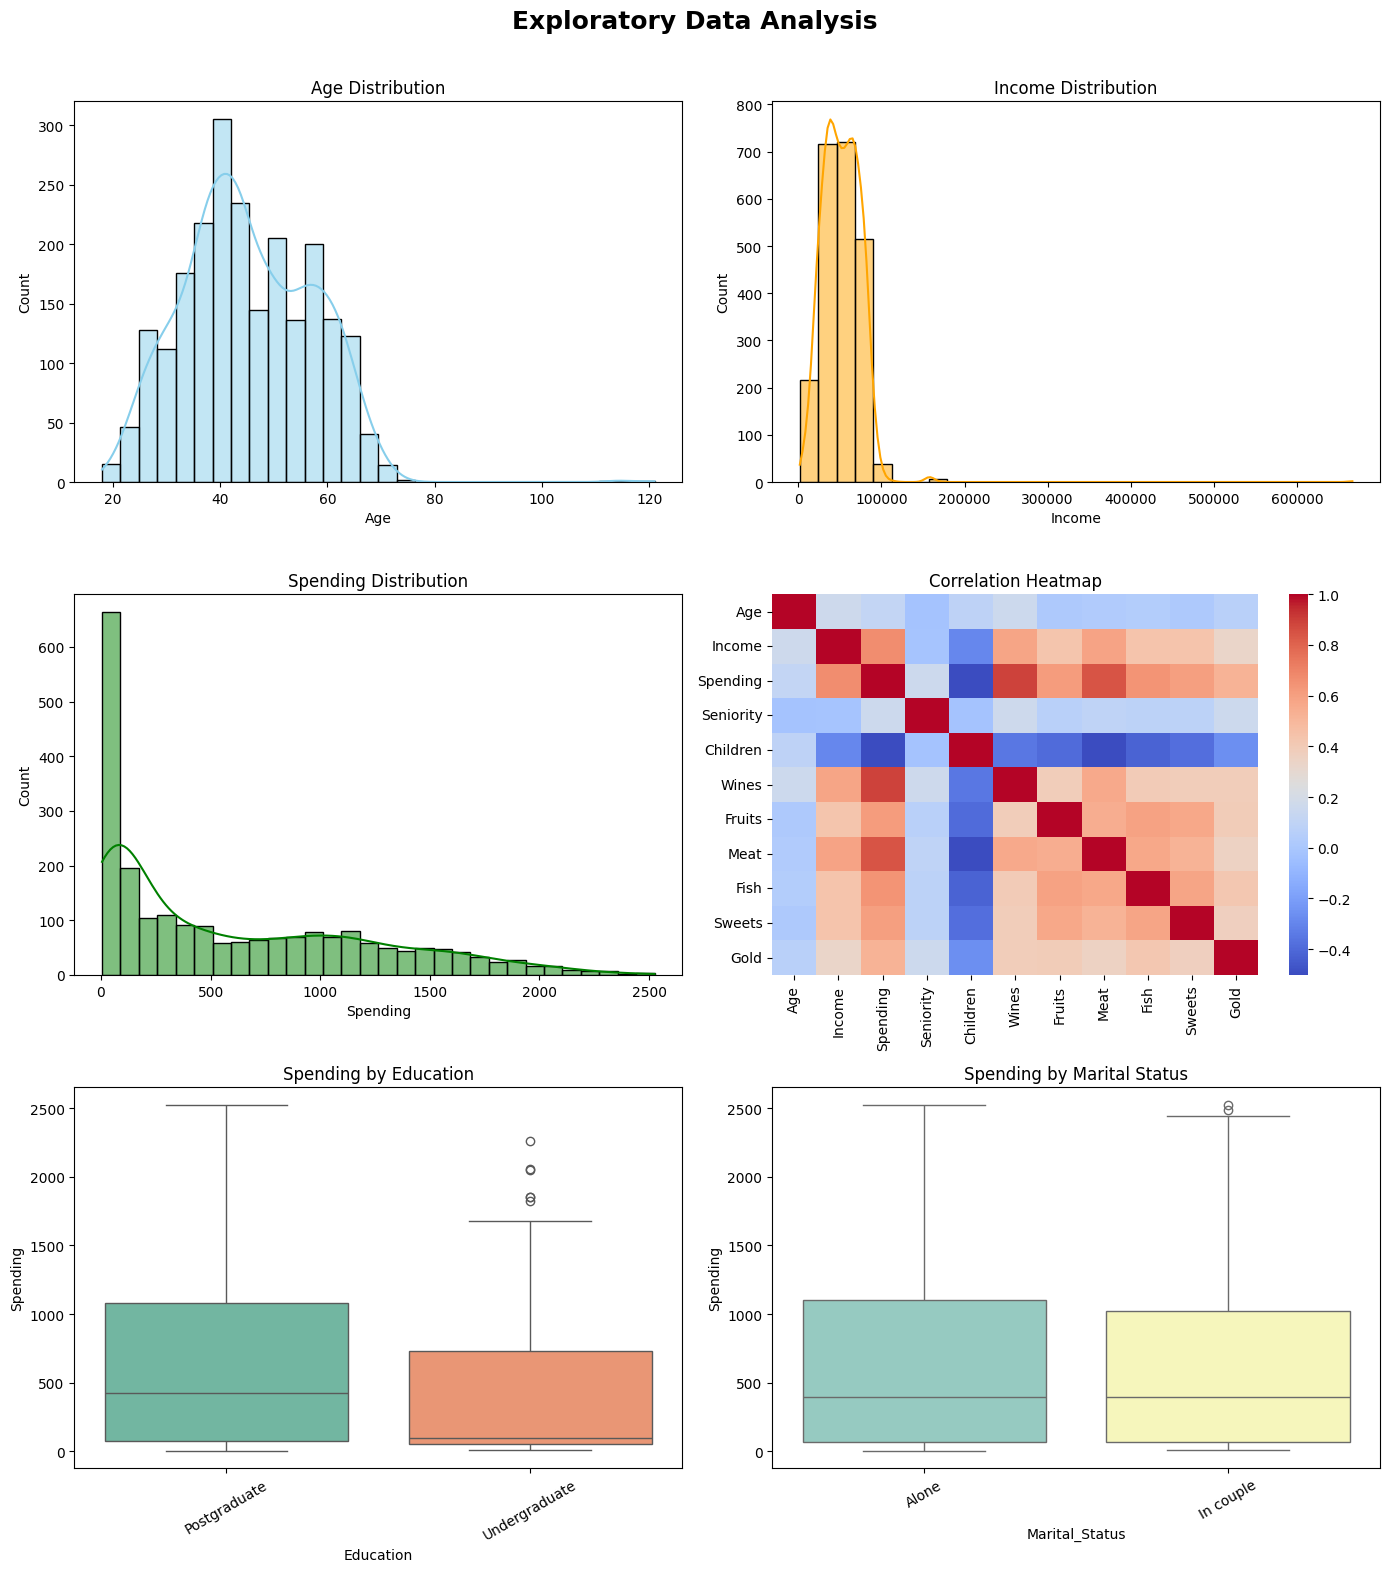

In [6]:


# Create the figure
fig, axes = plt.subplots(3, 2, figsize=(14, 16))
fig.suptitle("Exploratory Data Analysis", fontsize=18, fontweight="bold")

# 1. Distribution of Age
sns.histplot(data['Age'], bins=30, kde=True, color="skyblue", ax=axes[0,0])
axes[0,0].set_title("Age Distribution")

# 2. Distribution of Income
sns.histplot(data['Income'], bins=30, kde=True, color="orange", ax=axes[0,1])
axes[0,1].set_title("Income Distribution")

# 3. Distribution of Spending
sns.histplot(data['Spending'], bins=30, kde=True, color="green", ax=axes[1,0])
axes[1,0].set_title("Spending Distribution")

# 4. Correlation heatmap
numeric_cols = data.select_dtypes(include=['int64','float64']).columns
corr = data[numeric_cols].corr()
sns.heatmap(corr, annot=False, cmap="coolwarm", ax=axes[1,1])
axes[1,1].set_title("Correlation Heatmap")

# 5. Spending by Education
sns.boxplot(x="Education", y="Spending", data=data, palette="Set2", ax=axes[2,0])
axes[2,0].set_title("Spending by Education")
axes[2,0].tick_params(axis="x", rotation=30)

# 6. Spending by Marital_Status
sns.boxplot(x="Marital_Status", y="Spending", data=data, palette="Set3", ax=axes[2,1])
axes[2,1].set_title("Spending by Marital Status")
axes[2,1].tick_params(axis="x", rotation=30)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


In [7]:
# 1. Handle missing values in Income (impute with median)
data['Income'].fillna(data['Income'].median(), inplace=True)

# 2. Select numeric features for scaling
num_features = ['Age', 'Income', 'Spending', 'Seniority']
scaler = StandardScaler()
data[num_features] = scaler.fit_transform(data[num_features])

# 3. Encode categorical variables using one-hot encoding
cat_features = ['Education', 'Marital_Status', 'Has_child']
data = pd.get_dummies(data, columns=cat_features, drop_first=True)

print(data.shape)
print(data.head())

(2240, 14)
        Age    Income  Spending  Seniority  Children  Wines  Fruits  Meat  \
0  0.985345  0.235696  1.679417   1.531185         0    635      88   546   
1  1.235733 -0.235454 -0.961275  -1.190545         2     11       1     6   
2  0.317643  0.773999  0.282673  -0.205773         0    426      49   127   
3 -1.268149 -1.022355 -0.918094  -1.061881         1     11       4    20   
4 -1.017761  0.241888 -0.305254  -0.953012         1    173      43   118   

   Fish  Sweets  Gold  Education_Undergraduate  Marital_Status_In couple  \
0   172      88    88                    False                     False   
1     2       1     6                    False                     False   
2   111      21    42                    False                      True   
3    10       3     5                    False                      True   
4    46      27    15                    False                      True   

   Has_child_No child  
0                True  
1               False

In [8]:
# Prepare feature matrix for clustering
X = data.drop(columns=['Children'])  # drop coz i consider it redundant with Has_child
# or keep it if you want to test both

print(X.shape)
print(X.head())


(2240, 13)
        Age    Income  Spending  Seniority  Wines  Fruits  Meat  Fish  Sweets  \
0  0.985345  0.235696  1.679417   1.531185    635      88   546   172      88   
1  1.235733 -0.235454 -0.961275  -1.190545     11       1     6     2       1   
2  0.317643  0.773999  0.282673  -0.205773    426      49   127   111      21   
3 -1.268149 -1.022355 -0.918094  -1.061881     11       4    20    10       3   
4 -1.017761  0.241888 -0.305254  -0.953012    173      43   118    46      27   

   Gold  Education_Undergraduate  Marital_Status_In couple  Has_child_No child  
0    88                    False                     False                True  
1     6                    False                     False               False  
2    42                    False                      True                True  
3     5                    False                      True               False  
4    15                    False                      True               False  


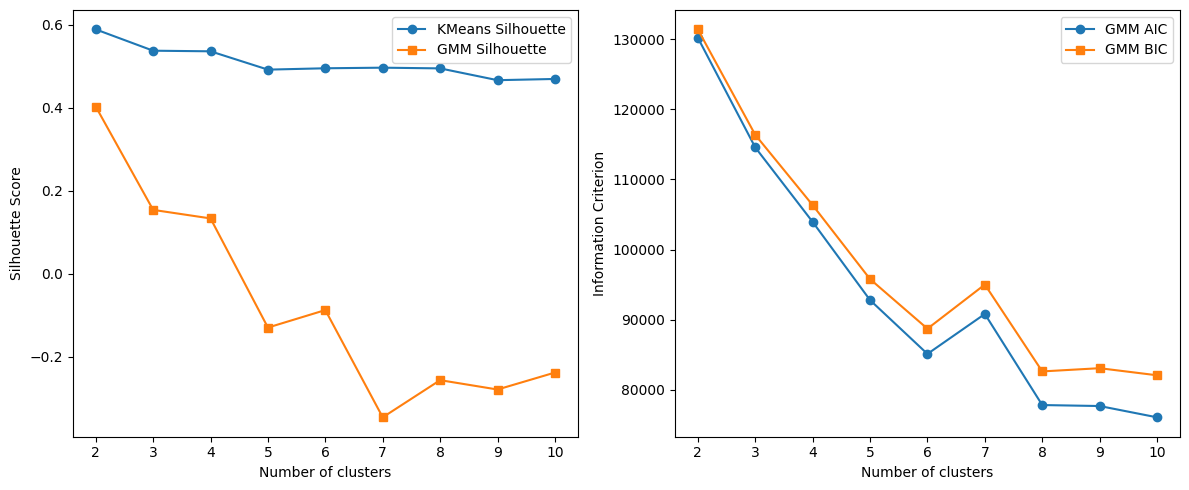

In [9]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Range of clusters to try
k_range = range(2, 11)

kmeans_sil = []
gmm_sil = []
gmm_aic = []
gmm_bic = []

for k in k_range:
    # KMeans
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_kmeans = kmeans.fit_predict(X)
    kmeans_sil.append(silhouette_score(X, labels_kmeans))
    
    # GMM
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm_labels = gmm.fit_predict(X)
    gmm_sil.append(silhouette_score(X, gmm_labels))
    gmm_aic.append(gmm.aic(X))
    gmm_bic.append(gmm.bic(X))

# Plot evaluation
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(k_range, kmeans_sil, marker='o', label='KMeans Silhouette')
plt.plot(k_range, gmm_sil, marker='s', label='GMM Silhouette')
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.legend()

plt.subplot(1,2,2)
plt.plot(k_range, gmm_aic, marker='o', label='GMM AIC')
plt.plot(k_range, gmm_bic, marker='s', label='GMM BIC')
plt.xlabel("Number of clusters")
plt.ylabel("Information Criterion")
plt.legend()

plt.tight_layout()
plt.show()


In [10]:
# Final clustering with KMeans ( k=4)
final_k = 4
kmeans = KMeans(n_clusters=final_k, random_state=42, n_init=10)
data['Cluster'] = kmeans.fit_predict(X)

# Check cluster sizes
print(data['Cluster'].value_counts())

# Cluster profiles
cluster_summary = data.groupby('Cluster').mean(numeric_only=True)
print(cluster_summary)


Cluster
0    1209
2     554
1     277
3     200
Name: count, dtype: int64
              Age    Income  Spending  Seniority  Children       Wines  \
Cluster                                                                  
0       -0.147995 -0.572858 -0.772093  -0.109933  1.214227   57.980149   
1        0.227250  0.838654  1.538823   0.343450  0.537906  979.624549   
2        0.223936  0.456206  0.359358   0.009705  0.884477  424.162455   
3       -0.040412  1.037700  1.540606   0.161982  0.110000  521.880000   

            Fruits        Meat        Fish     Sweets       Gold  \
Cluster                                                            
0         8.267163   33.835401   11.566584   8.336642  20.923904   
1        44.599278  330.133574   64.003610  45.299639  68.685921   
2        40.548736  185.810469   56.805054  43.178700  71.667870   
3        70.520000  693.375000  104.370000  70.365000  72.910000   

         Education_Undergraduate  Marital_Status_In couple  Has_child_No

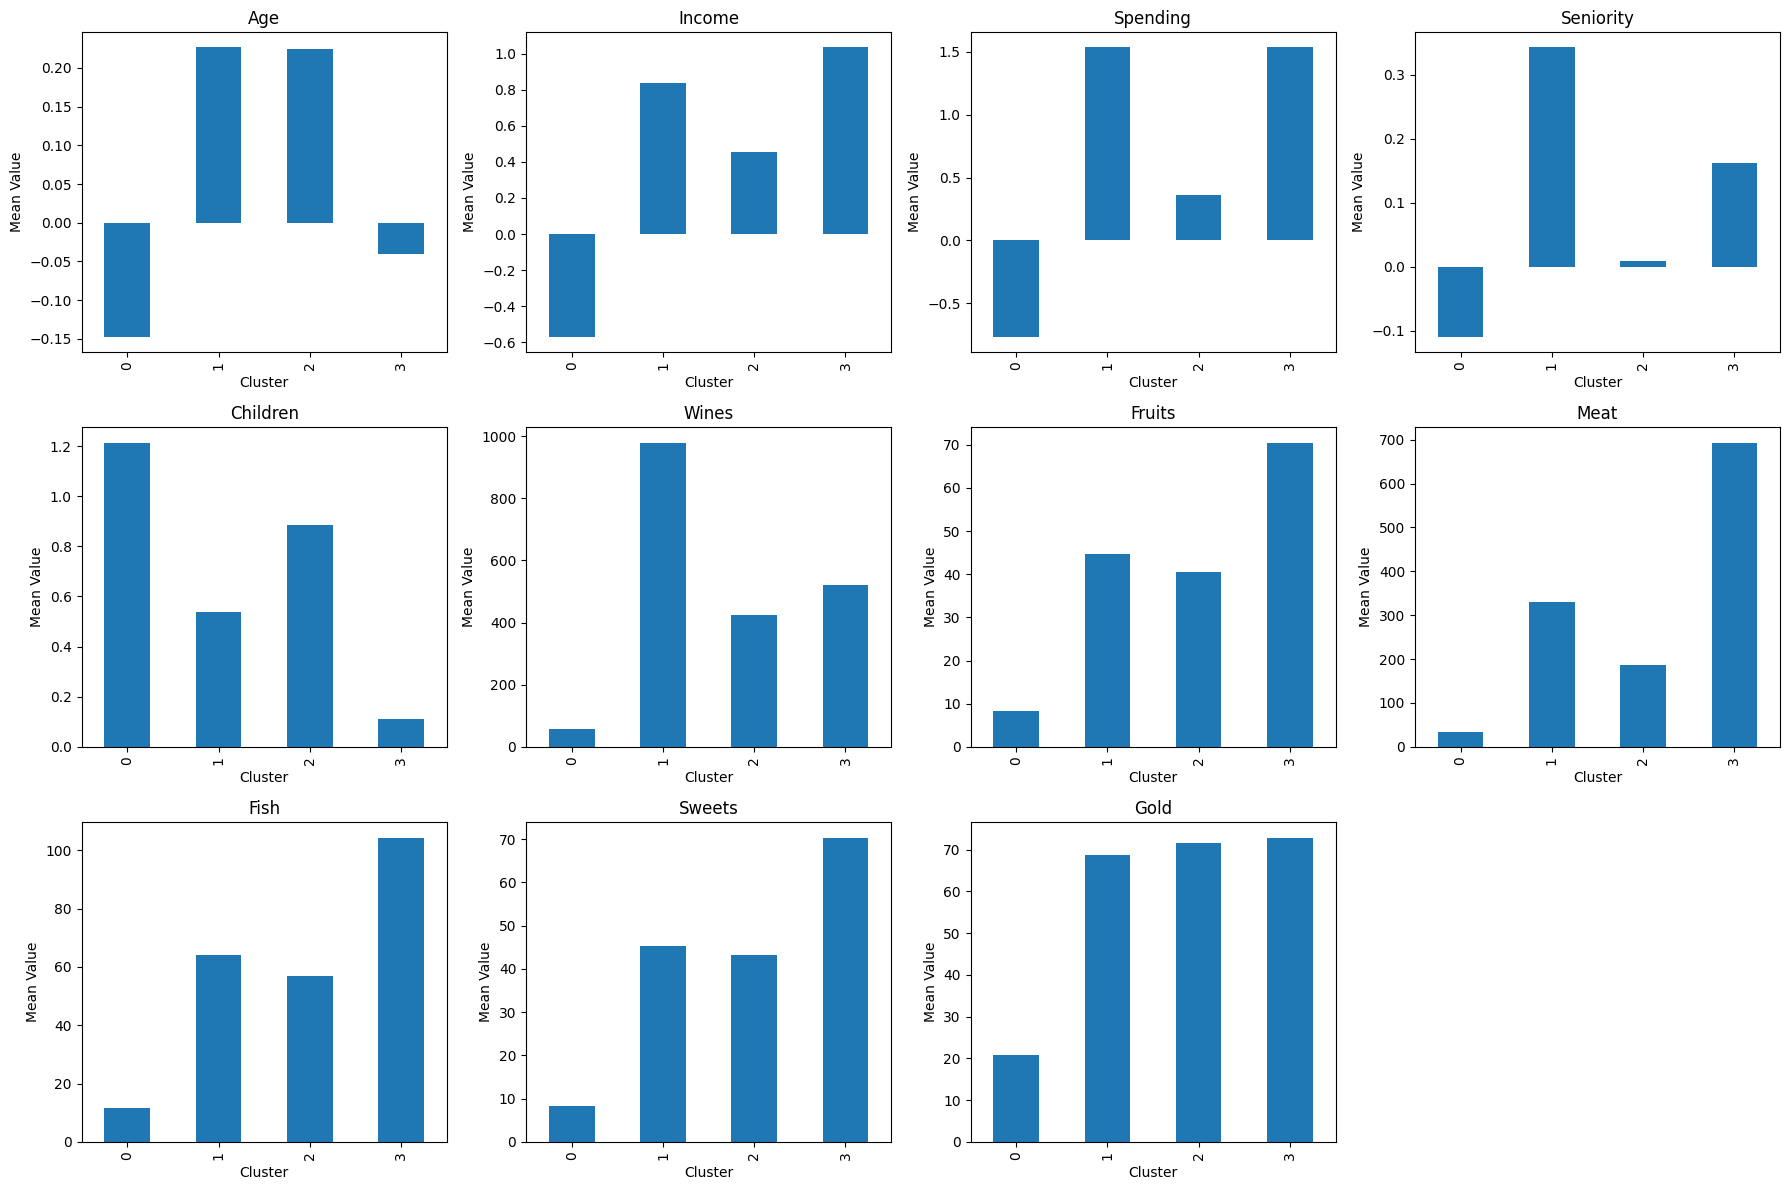

In [11]:
import matplotlib.pyplot as plt

# Select key features for profiling
features = ["Age", "Income", "Spending", "Seniority", "Children", 
            "Wines", "Fruits", "Meat", "Fish", "Sweets", "Gold"]

# Plot cluster means for each feature
cluster_profile = data.groupby("Cluster")[features].mean()

# Create bar charts
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(18, 12))
axes = axes.flatten()

for i, feature in enumerate(features):
    cluster_profile[feature].plot(kind="bar", ax=axes[i])
    axes[i].set_title(feature)
    axes[i].set_xlabel("Cluster")
    axes[i].set_ylabel("Mean Value")

# Remove extra subplot if not needed
for j in range(len(features), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


CLUSTER QUALITY EVALUATION
Silhouette Score: 0.536
Calinski-Harabasz Index: 2832.0
Davies-Bouldin Index: 0.885

Score Interpretation:
• Silhouette Score: 0.536 (Good)
• Calinski-Harabasz: 2832.0 (Higher is better - indicates well-separated clusters)
• Davies-Bouldin: 0.885 (Lower is better - indicates compact and well-separated clusters)


DETAILED SILHOUETTE ANALYSIS


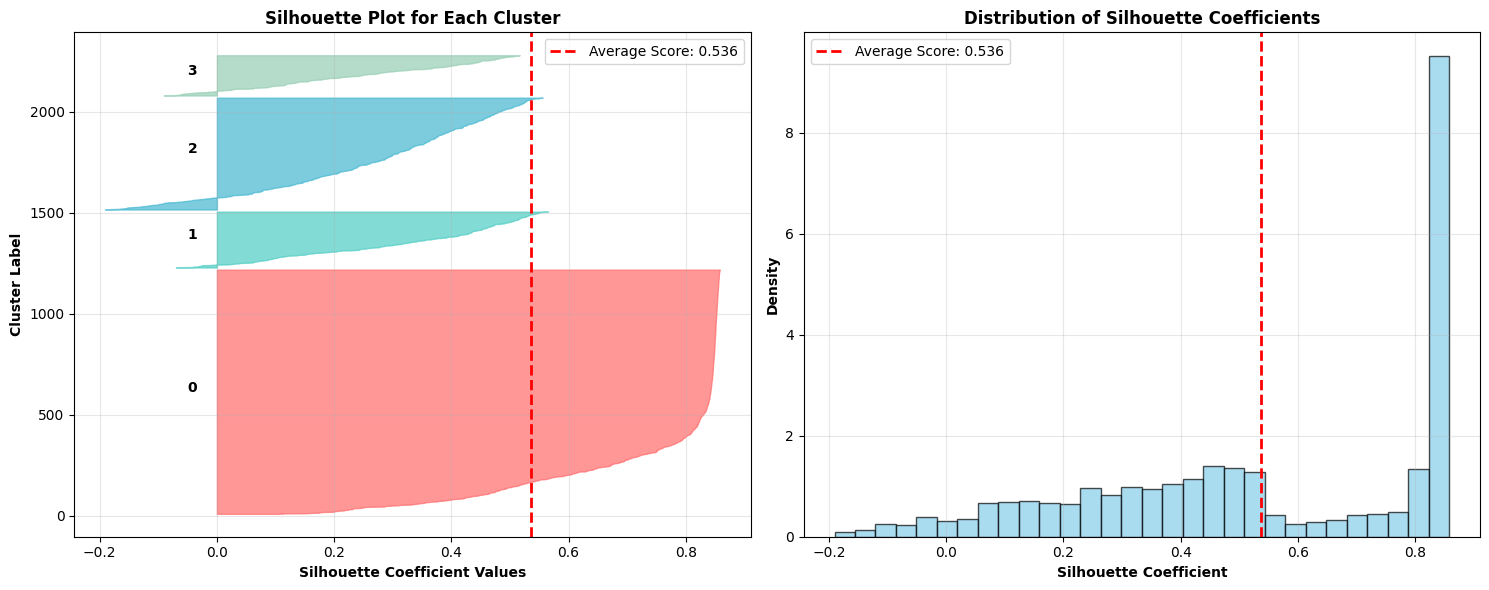


Cluster-wise Silhouette Statistics:
Cluster 0: Size=1209, Avg Silhouette=0.756, Std=0.164, Min=0.102, Max=0.858
Cluster 1: Size= 277, Avg Silhouette=0.320, Std=0.177, Min=-0.070, Max=0.565
Cluster 2: Size= 554, Avg Silhouette=0.273, Std=0.186, Min=-0.191, Max=0.556
Cluster 3: Size= 200, Avg Silhouette=0.240, Std=0.175, Min=-0.091, Max=0.517


CLUSTER CHARACTERISTICS ANALYSIS
Cluster Distribution:
Cluster 0: 1,209 customers (54.0%)
Cluster 1: 277 customers (12.4%)
Cluster 2: 554 customers (24.7%)
Cluster 3: 200 customers (8.9%)

Detailed Cluster Profiles:

CLUSTER 0 PROFILE:
  • Age         :     -0.1 (+88029697481402928%) Very High
  • Income      :     -0.6 (+1313414872089870336%) Very High
  • Spending    :     -0.8 (-2116553859491866880%) Very Low
  • Seniority   :     -0.1 (+25624011655294228%) Very High
  • Children    :      1.2 (  +28%) High
  • Wines       :     58.0 (  -81%) Very Low
  • Fruits      :      8.3 (  -69%) Very Low
  • Meat        :     33.8 (  -80%) Very Low
  •

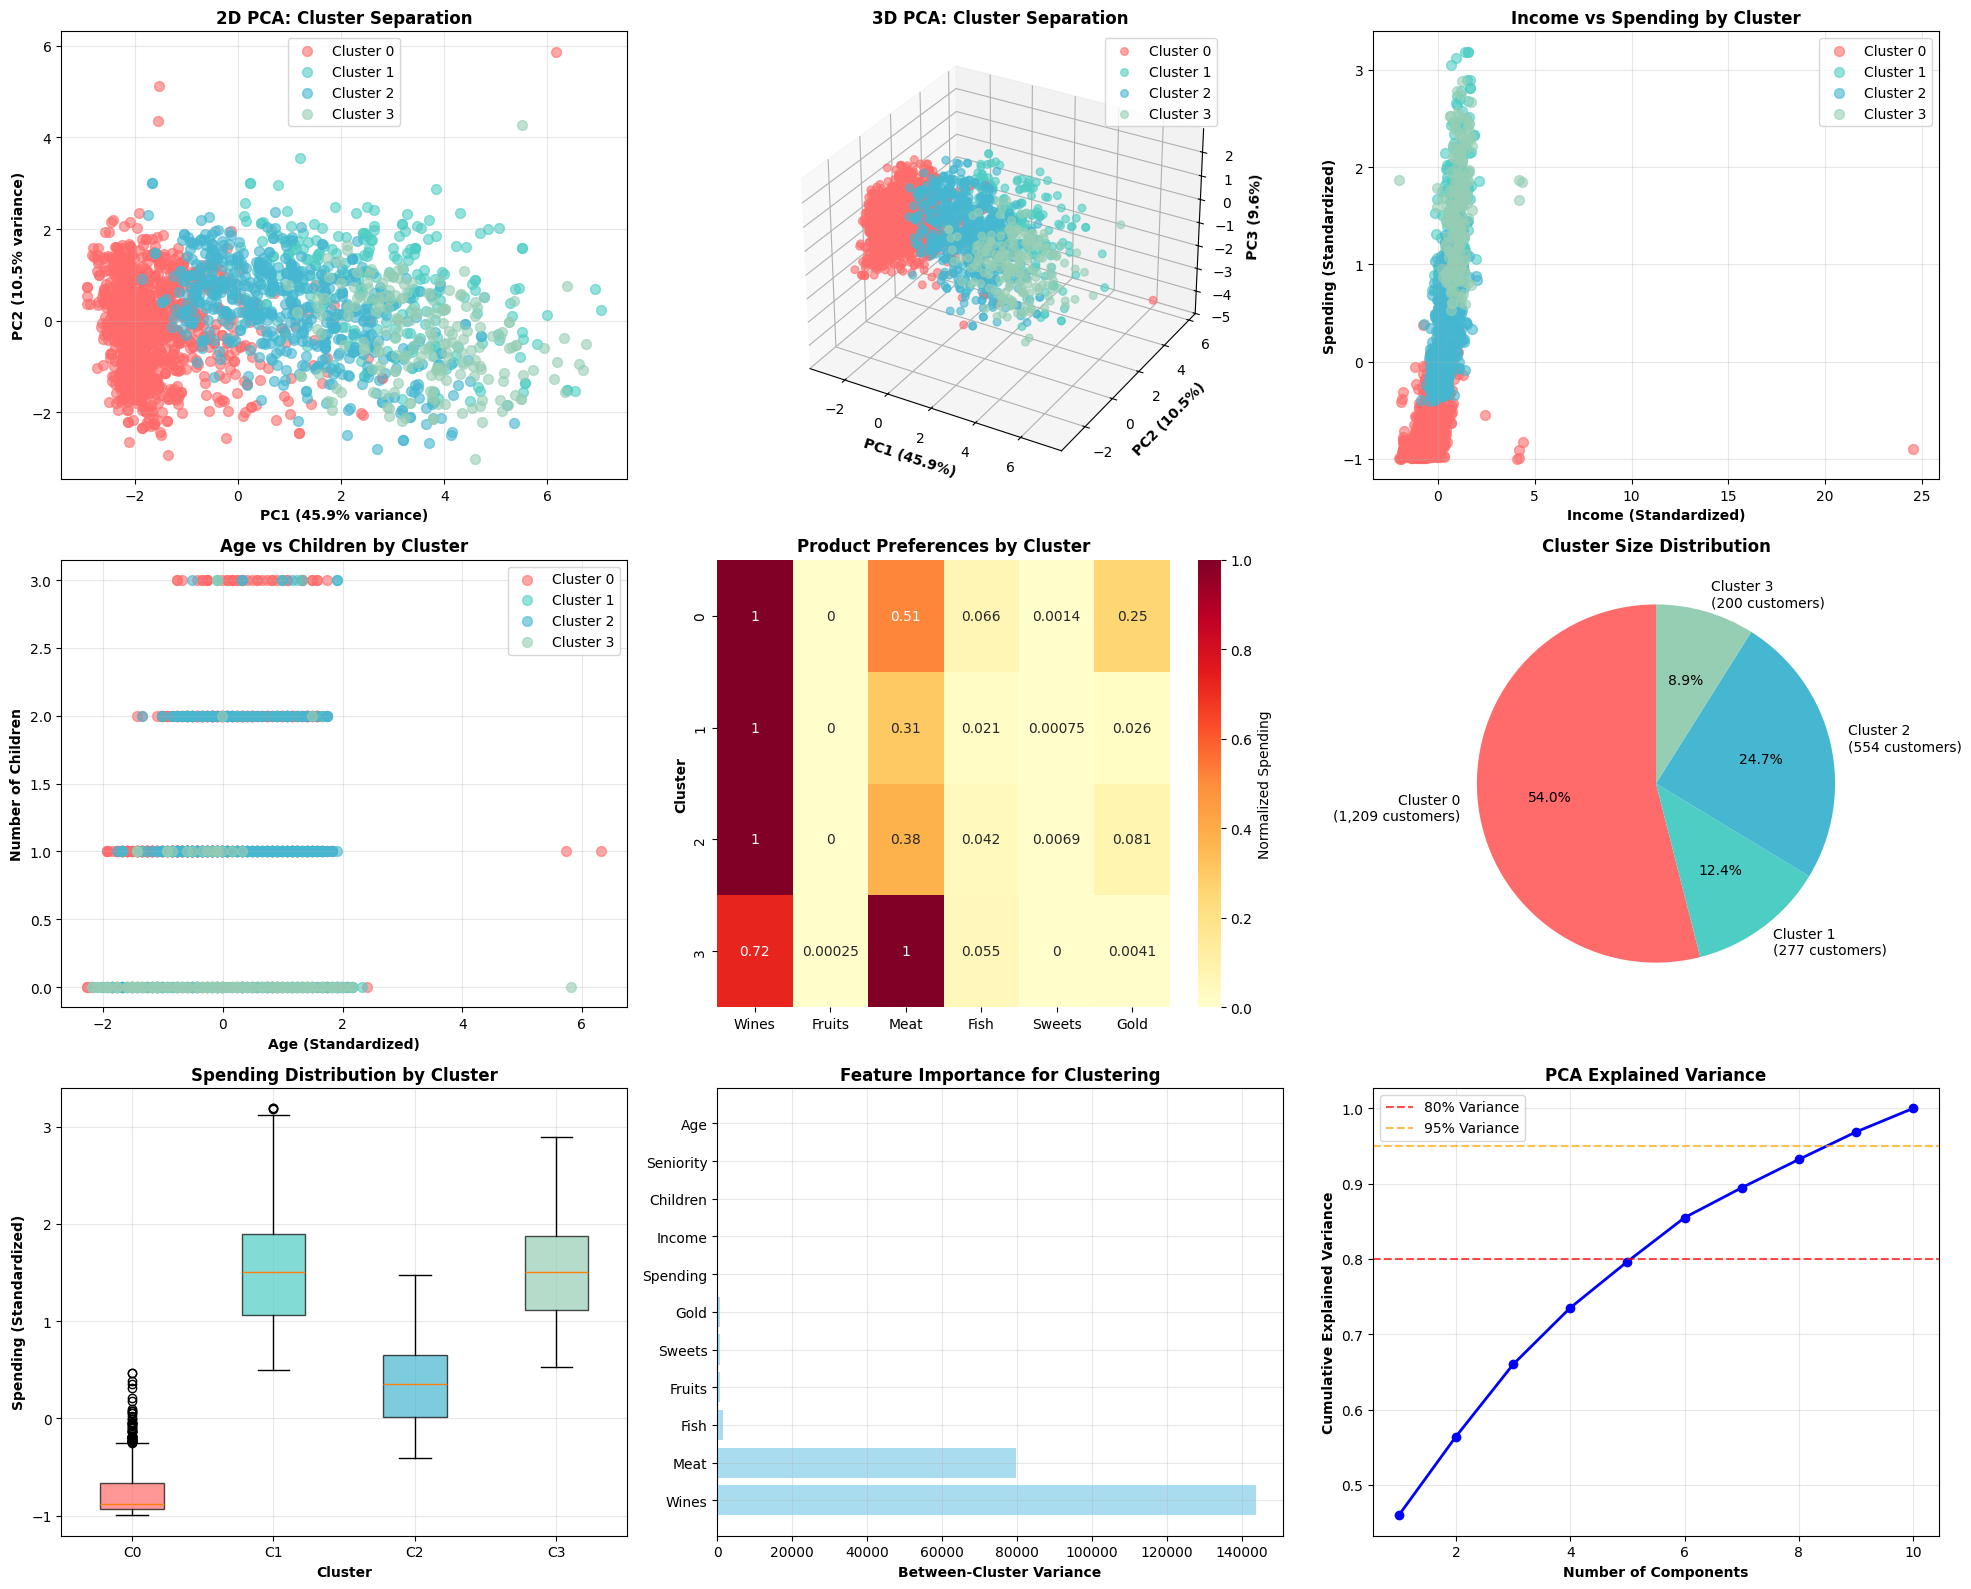


PCA Analysis Results:
• First 2 components explain 56.4% of total variance
• First 3 components explain 66.0% of total variance


BUSINESS INTERPRETATION & ACTIONABLE INSIGHTS

CLUSTER 0: Budget-Conscious Families
Size: 1,209 customers (54.0% of total)
Business Value: High volume, low margin segment

Key Characteristics:
   • Low income
   • High number of children
   • Low spending
   • Price-sensitive

Recommended Marketing Strategy:
   • Value pricing and bulk discounts
   • Family-oriented product bundles
   • Cost-effective marketing channels
   • Essential products focus

Revenue Potential: Stable base revenue through volume

CLUSTER 1: Premium Wine Enthusiasts
Size: 277 customers (12.4% of total)
Business Value: Specialty segment with high engagement

Key Characteristics:
   • High wine spending
   • Moderate income
   • Quality-focused
   • Brand loyal

Recommended Marketing Strategy:
   • Premium wine curation and education
   • Wine tasting events and experiences
   • Loyalt

In [12]:
# 1. CLUSTER QUALITY METRICS
print("CLUSTER QUALITY EVALUATION")

# Calculate silhouette score for your 4-cluster solution
from sklearn.metrics import silhouette_score, silhouette_samples, calinski_harabasz_score, davies_bouldin_score

# Prepare feature matrix (assuming you have standardized features)
numerical_features = ['Age', 'Income', 'Spending', 'Seniority', 'Children', 
                     'Wines', 'Fruits', 'Meat', 'Fish', 'Sweets', 'Gold']

# Remove any columns that don't exist in your data
available_features = [col for col in numerical_features if col in data.columns]
X_analysis = data[available_features].fillna(data[available_features].median())

# Quality metrics for k=4
silhouette_avg = silhouette_score(X_analysis, data['Cluster'])
calinski_harabasz = calinski_harabasz_score(X_analysis, data['Cluster'])
davies_bouldin = davies_bouldin_score(X_analysis, data['Cluster'])

print(f"Silhouette Score: {silhouette_avg:.3f}")
print(f"Calinski-Harabasz Index: {calinski_harabasz:.1f}")
print(f"Davies-Bouldin Index: {davies_bouldin:.3f}")

# Interpretation of scores
print("\nScore Interpretation:")
print(f"• Silhouette Score: {silhouette_avg:.3f} ({'Excellent' if silhouette_avg > 0.7 else 'Good' if silhouette_avg > 0.5 else 'Fair' if silhouette_avg > 0.25 else 'Poor'})")
print(f"• Calinski-Harabasz: {calinski_harabasz:.1f} (Higher is better - indicates well-separated clusters)")
print(f"• Davies-Bouldin: {davies_bouldin:.3f} (Lower is better - indicates compact and well-separated clusters)")

# 2. DETAILED SILHOUETTE ANALYSIS
print("\n\nDETAILED SILHOUETTE ANALYSIS")

sample_silhouette_values = silhouette_samples(X_analysis, data['Cluster'])

# Create silhouette plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Silhouette plot for each cluster
y_lower = 10
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

for i in range(4):
    cluster_silhouette_values = sample_silhouette_values[data['Cluster'] == i]
    cluster_silhouette_values.sort()
    
    size_cluster_i = cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                     0, cluster_silhouette_values,
                     facecolor=colors[i], edgecolor=colors[i], alpha=0.7)
    
    # Label clusters
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i), fontweight='bold')
    y_lower = y_upper + 10

ax1.set_xlabel('Silhouette Coefficient Values', fontweight='bold')
ax1.set_ylabel('Cluster Label', fontweight='bold')
ax1.set_title('Silhouette Plot for Each Cluster', fontweight='bold')
ax1.axvline(x=silhouette_avg, color="red", linestyle="--", linewidth=2,
            label=f'Average Score: {silhouette_avg:.3f}')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Distribution of silhouette scores
ax2.hist(sample_silhouette_values, bins=30, alpha=0.7, color='skyblue', 
         edgecolor='black', density=True)
ax2.axvline(x=silhouette_avg, color="red", linestyle="--", linewidth=2,
            label=f'Average Score: {silhouette_avg:.3f}')
ax2.set_xlabel('Silhouette Coefficient', fontweight='bold')
ax2.set_ylabel('Density', fontweight='bold')
ax2.set_title('Distribution of Silhouette Coefficients', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Cluster-wise silhouette statistics
print("\nCluster-wise Silhouette Statistics:")
for i in range(4):
    cluster_sil = sample_silhouette_values[data['Cluster'] == i]
    cluster_size = len(cluster_sil)
    print(f"Cluster {i}: Size={cluster_size:4d}, Avg Silhouette={cluster_sil.mean():.3f}, "
          f"Std={cluster_sil.std():.3f}, Min={cluster_sil.min():.3f}, Max={cluster_sil.max():.3f}")

# 3. CLUSTER CHARACTERISTICS ANALYSIS
print("\n\nCLUSTER CHARACTERISTICS ANALYSIS")

# Basic cluster distribution
cluster_counts = data['Cluster'].value_counts().sort_index()
print("Cluster Distribution:")
for cluster in sorted(data['Cluster'].unique()):
    count = cluster_counts[cluster]
    percentage = (count / len(data)) * 100
    print(f"Cluster {cluster}: {count:,} customers ({percentage:.1f}%)")

# Statistical analysis for each cluster
print("\nDetailed Cluster Profiles:")

cluster_profiles = data.groupby('Cluster')[available_features].agg(['mean', 'std']).round(2)

# More readable format
for cluster in sorted(data['Cluster'].unique()):
    cluster_data = data[data['Cluster'] == cluster]
    print(f"\nCLUSTER {cluster} PROFILE:")
    
    for feature in available_features:
        cluster_mean = cluster_data[feature].mean()
        overall_mean = data[feature].mean()
        difference_pct = ((cluster_mean / overall_mean) - 1) * 100
        
        # Determine significance level
        if abs(difference_pct) > 50:
            significance = "Very High" if difference_pct > 0 else "Very Low"
        elif abs(difference_pct) > 25:
            significance = "High" if difference_pct > 0 else "Low"
        elif abs(difference_pct) > 10:
            significance = "Above Average" if difference_pct > 0 else "Below Average"
        else:
            significance = "Average"
        
        if abs(difference_pct) > 10:  # Only show significant differences
            print(f"  • {feature:12}: {cluster_mean:8.1f} ({difference_pct:+5.0f}%) {significance}")

# 4. STATISTICAL SIGNIFICANCE TESTING
print("\n\nSTATISTICAL SIGNIFICANCE ANALYSIS (ANOVA)")

from scipy import stats
import pandas as pd

anova_results = []
for feature in available_features:
    # Get data for each cluster
    clusters = [data[data['Cluster'] == i][feature].dropna() for i in range(4)]
    
    # Perform ANOVA test
    f_stat, p_value = stats.f_oneway(*clusters)
    
    # Effect size (eta-squared)
    ss_between = sum(len(cluster) * (cluster.mean() - data[feature].mean())**2 for cluster in clusters)
    ss_total = ((data[feature] - data[feature].mean())**2).sum()
    eta_squared = ss_between / ss_total if ss_total > 0 else 0
    
    anova_results.append({
        'Feature': feature,
        'F-statistic': f_stat,
        'p-value': p_value,
        'Effect Size (η²)': eta_squared,
        'Significant': 'Yes' if p_value < 0.05 else 'No',
        'Effect': 'Large' if eta_squared > 0.14 else 'Medium' if eta_squared > 0.06 else 'Small'
    })

anova_df = pd.DataFrame(anova_results)
print(anova_df.round(4))

print("\nInterpretation:")
print("• p-value < 0.05: Significant difference between clusters")
print("• η² > 0.14: Large effect size, η² > 0.06: Medium effect, η² < 0.06: Small effect")

# 5. COMPREHENSIVE VISUALIZATION
print("\n\nCREATING CLUSTER VISUALIZATIONS...")

# PCA for dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize data for PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_analysis)

# 2D PCA
pca_2d = PCA(n_components=2, random_state=42)
X_pca_2d = pca_2d.fit_transform(X_scaled)

# 3D PCA
pca_3d = PCA(n_components=3, random_state=42)
X_pca_3d = pca_3d.fit_transform(X_scaled)

# Create comprehensive visualization
fig = plt.figure(figsize=(20, 16))

# 1. 2D PCA Scatter Plot
ax1 = plt.subplot(3, 3, 1)
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
for cluster in range(4):
    mask = data['Cluster'] == cluster
    plt.scatter(X_pca_2d[mask, 0], X_pca_2d[mask, 1], 
               c=colors[cluster], label=f'Cluster {cluster}', 
               alpha=0.6, s=50)

plt.xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.1%} variance)', fontweight='bold')
plt.ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.1%} variance)', fontweight='bold')
plt.title('2D PCA: Cluster Separation', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. 3D PCA Scatter Plot
ax2 = fig.add_subplot(3, 3, 2, projection='3d')
for cluster in range(4):
    mask = data['Cluster'] == cluster
    ax2.scatter(X_pca_3d[mask, 0], X_pca_3d[mask, 1], X_pca_3d[mask, 2],
               c=colors[cluster], label=f'Cluster {cluster}', alpha=0.6, s=30)

ax2.set_xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]:.1%})', fontweight='bold')
ax2.set_ylabel(f'PC2 ({pca_3d.explained_variance_ratio_[1]:.1%})', fontweight='bold')
ax2.set_zlabel(f'PC3 ({pca_3d.explained_variance_ratio_[2]:.1%})', fontweight='bold')
ax2.set_title('3D PCA: Cluster Separation', fontweight='bold')
ax2.legend()

# 3. Income vs Spending (key business metrics)
ax3 = plt.subplot(3, 3, 3)
for cluster in range(4):
    mask = data['Cluster'] == cluster
    plt.scatter(data.loc[mask, 'Income'], data.loc[mask, 'Spending'], 
               c=colors[cluster], label=f'Cluster {cluster}', alpha=0.6, s=50)

plt.xlabel('Income (Standardized)', fontweight='bold')
plt.ylabel('Spending (Standardized)', fontweight='bold')
plt.title('Income vs Spending by Cluster', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# 4. Age vs Children
ax4 = plt.subplot(3, 3, 4)
for cluster in range(4):
    mask = data['Cluster'] == cluster
    plt.scatter(data.loc[mask, 'Age'], data.loc[mask, 'Children'], 
               c=colors[cluster], label=f'Cluster {cluster}', alpha=0.6, s=50)

plt.xlabel('Age (Standardized)', fontweight='bold')
plt.ylabel('Number of Children', fontweight='bold')
plt.title('Age vs Children by Cluster', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# 5. Product preferences heatmap
ax5 = plt.subplot(3, 3, 5)
product_features = ['Wines', 'Fruits', 'Meat', 'Fish', 'Sweets', 'Gold']
available_products = [col for col in product_features if col in data.columns]

if available_products:
    product_means = data.groupby('Cluster')[available_products].mean()
    
    # Normalize for better visualization
    from sklearn.preprocessing import MinMaxScaler
    scaler_heatmap = MinMaxScaler()
    product_means_normalized = pd.DataFrame(
        scaler_heatmap.fit_transform(product_means.T).T,
        index=product_means.index,
        columns=product_means.columns
    )
    
    sns.heatmap(product_means_normalized, annot=True, cmap='YlOrRd', 
                cbar_kws={'label': 'Normalized Spending'})
    plt.title('Product Preferences by Cluster', fontweight='bold')
    plt.ylabel('Cluster', fontweight='bold')

# 6. Cluster size pie chart
ax6 = plt.subplot(3, 3, 6)
cluster_counts = data['Cluster'].value_counts().sort_index()
plt.pie(cluster_counts.values, 
        labels=[f'Cluster {i}\n({count:,} customers)' for i, count in enumerate(cluster_counts.values)], 
        autopct='%1.1f%%', colors=colors, startangle=90)
plt.title('Cluster Size Distribution', fontweight='bold')

# 7. Box plot for spending distribution
ax7 = plt.subplot(3, 3, 7)
spending_data = [data[data['Cluster'] == i]['Spending'] for i in range(4)]
box_plot = plt.boxplot(spending_data, patch_artist=True, labels=[f'C{i}' for i in range(4)])

for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

plt.xlabel('Cluster', fontweight='bold')
plt.ylabel('Spending (Standardized)', fontweight='bold')
plt.title('Spending Distribution by Cluster', fontweight='bold')
plt.grid(True, alpha=0.3)

# 8. Feature importance for clustering
ax8 = plt.subplot(3, 3, 8)
feature_variance = []
for feature in available_features:
    cluster_means = data.groupby('Cluster')[feature].mean()
    variance = cluster_means.var()
    feature_variance.append((feature, variance))

feature_variance.sort(key=lambda x: x[1], reverse=True)
features, variances = zip(*feature_variance)

plt.barh(range(len(features)), variances, color='skyblue', alpha=0.7)
plt.yticks(range(len(features)), features)
plt.xlabel('Between-Cluster Variance', fontweight='bold')
plt.title('Feature Importance for Clustering', fontweight='bold')
plt.grid(True, alpha=0.3)

# 9. Explained variance by PCA components
ax9 = plt.subplot(3, 3, 9)
pca_full = PCA(random_state=42)
pca_full.fit(X_scaled)

cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
plt.plot(range(1, min(11, len(cumulative_variance) + 1)), 
         cumulative_variance[:10], 'bo-', linewidth=2)
plt.axhline(y=0.8, color='red', linestyle='--', alpha=0.7, label='80% Variance')
plt.axhline(y=0.95, color='orange', linestyle='--', alpha=0.7, label='95% Variance')
plt.xlabel('Number of Components', fontweight='bold')
plt.ylabel('Cumulative Explained Variance', fontweight='bold')
plt.title('PCA Explained Variance', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nPCA Analysis Results:")
print(f"• First 2 components explain {pca_2d.explained_variance_ratio_.sum():.1%} of total variance")
print(f"• First 3 components explain {pca_3d.explained_variance_ratio_.sum():.1%} of total variance")

# 6. BUSINESS INTERPRETATION OF CLUSTERS
print("\n\nBUSINESS INTERPRETATION & ACTIONABLE INSIGHTS")

cluster_interpretations = {
    0: {
        'name': 'Budget-Conscious Families',
        'key_traits': ['Low income', 'High number of children', 'Low spending', 'Price-sensitive'],
        'business_value': 'High volume, low margin segment',
        'marketing_strategy': [
            'Value pricing and bulk discounts',
            'Family-oriented product bundles', 
            'Cost-effective marketing channels',
            'Essential products focus'
        ],
        'revenue_potential': 'Stable base revenue through volume'
    },
    1: {
        'name': 'Premium Wine Enthusiasts', 
        'key_traits': ['High wine spending', 'Moderate income', 'Quality-focused', 'Brand loyal'],
        'business_value': 'Specialty segment with high engagement',
        'marketing_strategy': [
            'Premium wine curation and education',
            'Wine tasting events and experiences',
            'Loyalty programs with exclusive access',
            'Content marketing about wine culture'
        ],
        'revenue_potential': 'Growth through premium positioning'
    },
    2: {
        'name': 'Balanced Middle-Income Shoppers',
        'key_traits': ['Moderate spending across categories', 'Diverse preferences', 'Price-conscious but not extreme'],
        'business_value': 'Versatile segment responsive to promotions',
        'marketing_strategy': [
            'Cross-selling across product categories',
            'Seasonal and promotional campaigns',
            'Mid-range product positioning',
            'Flexible payment and delivery options'
        ],
        'revenue_potential': 'Growth through category expansion'
    },
    3: {
        'name': 'Affluent Gourmet Food Lovers',
        'key_traits': ['Highest spending', 'No children', 'Premium food focus', 'High disposable income'],
        'business_value': 'Highest value segment with premium potential',
        'marketing_strategy': [
            'Luxury and artisanal product lines',
            'Personalized shopping experiences',
            'Exclusive events and early access',
            'Premium customer service'
        ],
        'revenue_potential': 'Maximum profitability per customer'
    }
}

for cluster_id in range(4):
    cluster_size = cluster_counts[cluster_id]
    cluster_pct = (cluster_size / len(data)) * 100
    interp = cluster_interpretations[cluster_id]
    
    print(f"\nCLUSTER {cluster_id}: {interp['name']}")
    print(f"Size: {cluster_size:,} customers ({cluster_pct:.1f}% of total)")
    print(f"Business Value: {interp['business_value']}")
    
    print("\nKey Characteristics:")
    for trait in interp['key_traits']:
        print(f"   • {trait}")
    
    print("\nRecommended Marketing Strategy:")
    for strategy in interp['marketing_strategy']:
        print(f"   • {strategy}")
    
    print(f"\nRevenue Potential: {interp['revenue_potential']}")

# 7. CLUSTER QUALITY SUMMARY
print(f"\n\nCLUSTER QUALITY SUMMARY")

print(f"• Silhouette Score: {silhouette_avg:.3f} ({'Good separation' if silhouette_avg > 0.5 else 'Moderate separation' if silhouette_avg > 0.25 else 'Poor separation'})")
print(f"• Statistical Significance: {sum(1 for result in anova_results if result['p-value'] < 0.05)}/{len(anova_results)} features show significant differences")
print(f"• Effect Sizes: {sum(1 for result in anova_results if result['Effect Size (η²)'] > 0.06)}/{len(anova_results)} features show medium-to-large effects")

# Recommendations for cluster quality
if silhouette_avg > 0.5:
    print("EXCELLENT: Clusters are well-separated and meaningful for business decisions")
elif silhouette_avg > 0.25:
    print("GOOD: Clusters provide reasonable segmentation for targeted marketing")
else:
    print("CAUTION: Consider alternative clustering approaches or feature engineering")

print("\nANALYSIS COMPLETE - Clusters are ready for business implementation!")

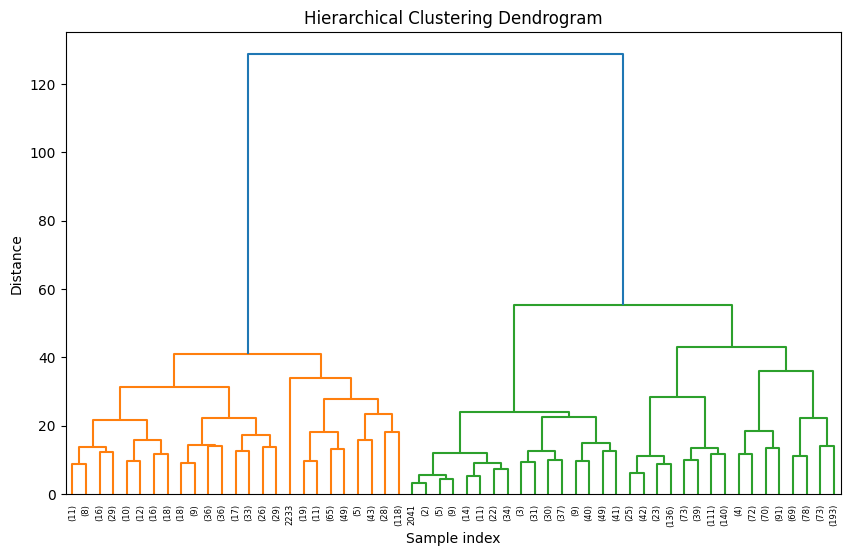

Agglomerative Clustering Silhouette Score: 0.127
Agglomerative_Cluster
0    663
1    650
3    589
2    338
Name: count, dtype: int64
Agglomerative_Cluster
0    663
1    650
3    589
2    338
Name: count, dtype: int64


In [14]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

# Linkage matrix for dendrogram
linked = linkage(X_scaled, method='ward')

# Plot dendrogram
plt.figure(figsize=(10, 6))
dendrogram(linked, truncate_mode='level', p=5)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

# Agglomerative Clustering
agg = AgglomerativeClustering(n_clusters=4, linkage='ward')  # no 'affinity' parameter
agg_labels = agg.fit_predict(X_scaled)

data['Agglomerative_Cluster'] = agg_labels

from sklearn.metrics import silhouette_score
agg_sil = silhouette_score(X_scaled, agg_labels)
print(f"Agglomerative Clustering Silhouette Score: {agg_sil:.3f}")
print(data['Agglomerative_Cluster'].value_counts())

print(data['Agglomerative_Cluster'].value_counts())


In [55]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.48, min_samples=20)
db_labels = db.fit_predict(X_scaled)


unique_labels = np.unique(db_labels)
print("Unique DBSCAN labels:", unique_labels)
print("Counts per label:", pd.Series(db_labels).value_counts())


Unique DBSCAN labels: [-1  0  1]
Counts per label: -1    2066
 0     154
 1      20
Name: count, dtype: int64


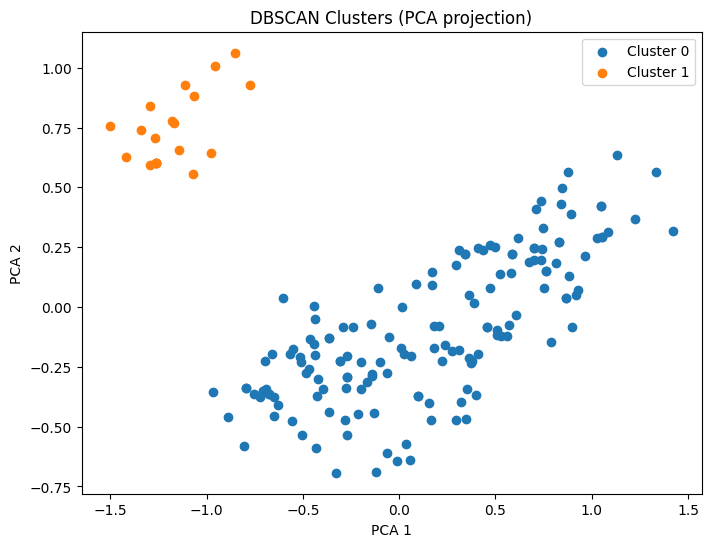

Silhouette Score (excluding noise): 0.459


In [56]:
# Exclude noise points (-1)
mask = db_labels != -1
X_clustered = X_scaled[mask]
labels_clustered = db_labels[mask]

# PCA to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_clustered)

# Plot clusters
plt.figure(figsize=(8,6))
for label in set(labels_clustered):
    plt.scatter(X_pca[labels_clustered == label, 0], X_pca[labels_clustered == label, 1], label=f'Cluster {label}')
plt.title('DBSCAN Clusters (PCA projection)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.show()

# Silhouette score
if len(set(labels_clustered)) > 1:
    sil_score = silhouette_score(X_clustered, labels_clustered)
    print(f'Silhouette Score (excluding noise): {sil_score:.3f}')
else:
    print("Not enough clusters to compute silhouette score.")